In [1]:
!pip install transformers

In [2]:
from transformers import BertModel
from transformers import BertTokenizer
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
import random
import matplotlib.pyplot as plt
import pandas as pd

torch.manual_seed(1)

In [3]:
class Trump_Tweet_Classification(nn.Module):
    def __init__(self, tokenizer_name, model_name):
        super().__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.embedder = BertModel.from_pretrained(model_name).to(self.device)
        for param in self.embedder.parameters():
            param.requires_grad = False
        self.tokenizer = BertTokenizer.from_pretrained(tokenizer_name)
        self.fc1 = nn.Linear(1024, 200).to(self.device)
        self.fc2 = nn.Linear(200, 40).to(self.device)
        self.fc3 = nn.Linear(40, 8).to(self.device)
        self.fc4 = nn.Linear(8, 1).to(self.device)
        
    def forward(self, sentence):
        input_token = self.tokenizer(sentence, return_tensors="pt", padding=True, truncation=True).to(self.device)
        output = self.embedder(**input_token)
        tensor = self.fc1(output[0][:, 0, :])
        tensor = F.leaky_relu(tensor)
        tensor = self.fc2(tensor)
        tensor = F.leaky_relu(tensor)
        tensor = self.fc3(tensor)
        tensor = F.leaky_relu(tensor)
        tensor = self.fc4(tensor)
        tensor = F.sigmoid(tensor)
        return tensor

In [4]:
classifier = Trump_Tweet_Classification("bert-large-uncased", "bert-large-uncased")

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
#Hyper parameters

#Looking at the loss graph, 1 epoch is enough
epochs = 1
batch_size = 128

In [6]:
criterion = nn.BCELoss()
optimizer = opt.Adam(classifier.parameters(), lr=3e-3)

In [7]:
read = open("Danjie_Tweets.txt", "r", encoding="latin1")
read = read.read()

read=read.replace("  ", " ")
read=read.lower()

read_list = read.split(".")
read_list_size = len(read_list)-1

In [8]:
x = []
y_real = []
y_fake = []

True Trump Loss:  0.69218809902668
Fake Trump Loss:  0.534543389081955


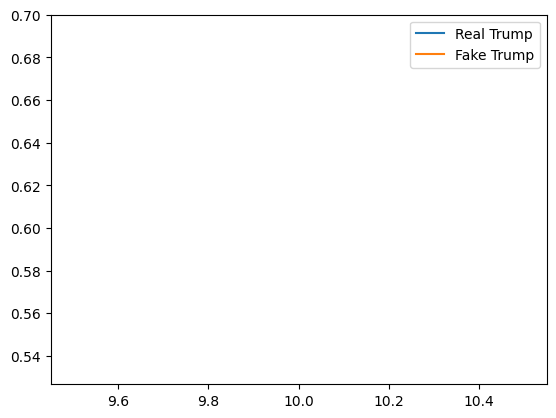

True Trump Loss:  0.2588424623012543
Fake Trump Loss:  0.1939132809638977


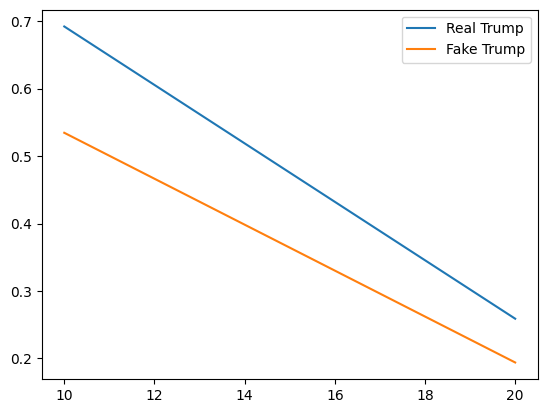

True Trump Loss:  0.04912953348830342
Fake Trump Loss:  0.034138746187090875


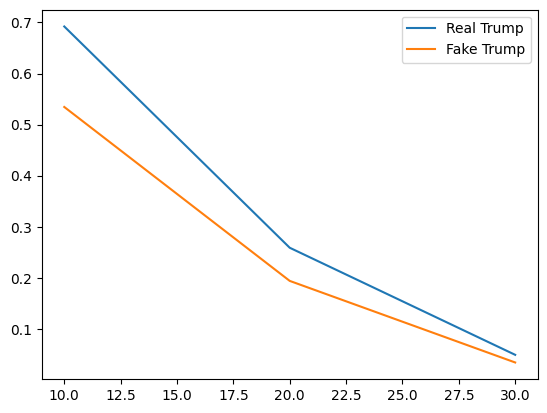

True Trump Loss:  0.013355814665555955
Fake Trump Loss:  0.008328185835853218


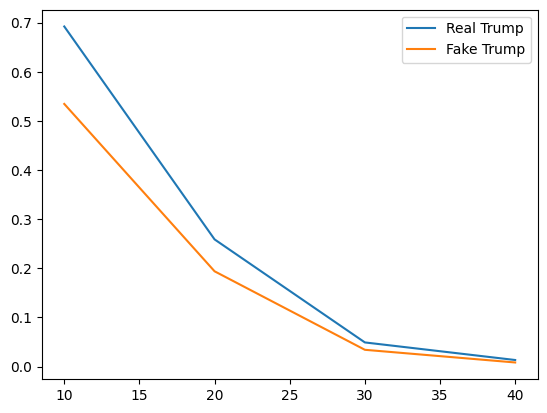

True Trump Loss:  0.005553039151709527
Fake Trump Loss:  0.0018547838146332652


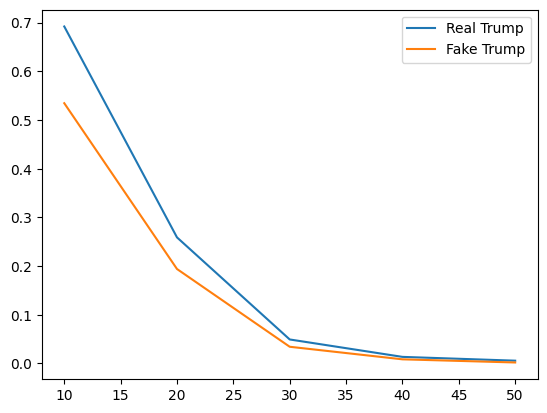

True Trump Loss:  0.003757300291908905
Fake Trump Loss:  0.0012425437627825886


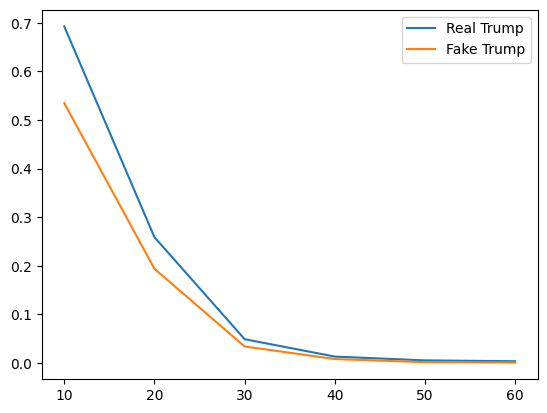

True Trump Loss:  0.0012172535789432004
Fake Trump Loss:  0.0013052540307398885


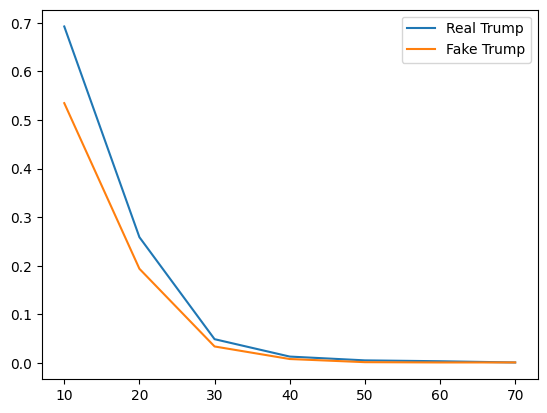

In [9]:
import pandas as pd

counter=0

df = pd.read_csv("Trump Tweet Data/realdonaldtrump.csv", chunksize=batch_size)

average_true_trump=0
average_fake_trump=0

# Records if we need to stop early
flag=False

for epoch in range(epochs):
    for chunk in df:
        counter+=1
        if(len(chunk["content"])!=batch_size):
            continue
        input = chunk["content"].astype(str).tolist()
        output = classifier(input)
        
        #Train according to the real trump tweets
        optimizer.zero_grad()
        loss = criterion(output, torch.ones_like(output))
        average_true_trump += loss.item()
        loss.backward()
        
        optimizer.step()
        
        list_of_random_sentences=[]
        k=0
        
        while(k<batch_size):
            #Get a random index of my sentences
            random_index = random.randint(0, read_list_size)
            
            sentence = read_list[random_index]
            if(sentence != "" and sentence != " " and sentence != " "):
                list_of_random_sentences.append(sentence)
                k+=1
        
        #Train according to the fake trump tweets
        output = classifier(list_of_random_sentences)
        optimizer.zero_grad()
        loss = criterion(output, torch.zeros_like(output))
        average_fake_trump += loss.item()
        loss.backward()
        
        optimizer.step()
        if(counter%10==0):
            x.append(counter)
            y_real.append(average_true_trump/10)
            y_fake.append(average_fake_trump/10)
            print("True Trump Loss: ", average_true_trump/10)
            print("Fake Trump Loss: ", average_fake_trump/10)

            plt.plot(x, y_real, label="Real Trump")
            plt.plot(x, y_fake, label="Fake Trump")
            plt.legend()
            plt.show()

            if((average_true_trump/10<0.003) and (average_fake_trump/10<0.003)):
                flag=True
                break;
            
            average_true_trump = 0
            average_fake_trump = 0

    if(flag):
        break

In [16]:
my_tweet = "I am going to wake up early tomorrow"

output = classifier(my_tweet)

print("The chance of this tweet is said by Donald Trump is: ", output[0].item()*100, "%")

The chance of this tweet is said by Donald Trump is:  0.0340961356414482 %
